In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import math
import json
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Pre-processing and Feature Engineering

### `portfolio` dataset

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# expand `channels` column which was in a list format into multiple dummy variables
portfolio_channels = pd.get_dummies(pd.DataFrame(portfolio['channels'].values.tolist()).stack()).sum(level=0)
portfolio = pd.concat([portfolio.drop(['channels'], axis=1), portfolio_channels], axis=1)
# create a identification variable to indicate offer types in multiple aspects
portfolio['offer_combo'] = (
    portfolio
    .filter(['offer_type', 'reward', 'difficulty', 'duration'])
    .astype(str)
    .agg('_'.join, axis=1)
)
portfolio 

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,offer_combo
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_10_7


### `profile` dataset

In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
profile = (
    profile
    .assign(member_year=profile['became_member_on'].astype(str).str[:4].astype(int),
           member_month=profile['became_member_on'].astype(str).str[4:6].astype(int),
           member_date=profile['became_member_on'].astype(str).str[6:8].astype(int))
    .drop(['became_member_on'], axis=1)
)
profile.head()

,gender,age,id,income,member_year,member_month,member_date
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4


We notice that there are 2,175 observations whose `gender` and `income` are NULL and `age` is listed as 118, which is impossible. These are likely related to customers who don't want to disclose their information. Instead of removing these records, we will build a predictive model to impute these values in later section.  

In [7]:
profile[profile['gender'].isnull()].head()

,gender,age,id,income,member_year,member_month,member_date
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,NaN,2017,10,2


### `transcript` dataset

In [8]:
def process_transcript(event_type):
    """
    Extract `offer id` from `value` column that is in dictionary format from `transcript`
    data. Rename columns as approriate. 
    :param event_type: event of offers (i.e: `received`, `viewed`, or `completed`)
    :return: processed data associated with specified event type
    """
    val_text = 'offer ' + event_type
    time_col = 'offer_' + event_type + '_time'
    key = 'offer_id' if event_type == 'completed' else 'offer id'
    data = (
        transcript
        .query('event == @val_text')
        .assign(offer_id=lambda x: [d.get(key) for d in x['value']])
        .rename(columns={'time': time_col})
        .filter(['person', 'offer_id', time_col])
    )
    return data

def create_offer_count_features(data, event_type):
    """
    Create new count features per person associated with each event type 
    (`receieved`, `viewed`, or `completed`) for each offer combination or offer type.
    :param data: processed data corresponding with specified event type
    :param event_type: event of offers (i.e: `received`, `viewed`, or `completed`)
    :return: data at customer level that includes newly created count features for different 
    offer types/combinations
    """
    old_col_name = 'offer_' + event_type + '_time'
    new_col_name = event_type + '_count'
    prefix = event_type + '_count_'
    grouped_data = (
        data
        .groupby(['person', 'offer_id'])
        .agg('count')
        .reset_index()
        .rename(columns={old_col_name: new_col_name})
        .merge(portfolio[['id', 'offer_combo']], how='left', left_on='offer_id', right_on='id')
        .filter(['person', 'offer_combo', new_col_name])
        .pivot(index='person', columns='offer_combo', values=new_col_name)
        .fillna(0)
        .assign(bogo_total=lambda x: x.filter(regex='bogo').sum(axis=1), 
               discount_total=lambda x: x.filter(regex='discount').sum(axis=1),
               informational_total=lambda x: x.filter(regex='informational').sum(axis=1),
               total=lambda x: x.filter(regex='total').sum(axis=1))
        .add_prefix(prefix)
        .reset_index()
    )
    
    return grouped_data

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
# those who received the offers 
offer_received = process_transcript('received')
received_ct_ids = create_offer_count_features(offer_received, 'received')
received_ct_ids.head()

offer_combo,person,received_count_bogo_10_10_5,received_count_bogo_10_10_7,received_count_bogo_5_5_5,received_count_bogo_5_5_7,received_count_discount_2_10_10,received_count_discount_2_10_7,received_count_discount_3_7_7,received_count_discount_5_20_10,received_count_informational_0_0_3,received_count_informational_0_0_4,received_count_bogo_total,received_count_discount_total,received_count_informational_total,received_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,5.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,5.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,4.0


In [11]:
# those who viewed the offers
offer_viewed = process_transcript('viewed')
viewed_ct_ids = create_offer_count_features(offer_viewed, 'viewed')
viewed_ct_ids.head()

offer_combo,person,viewed_count_bogo_10_10_5,viewed_count_bogo_10_10_7,viewed_count_bogo_5_5_5,viewed_count_bogo_5_5_7,viewed_count_discount_2_10_10,viewed_count_discount_2_10_7,viewed_count_discount_3_7_7,viewed_count_discount_5_20_10,viewed_count_informational_0_0_3,viewed_count_informational_0_0_4,viewed_count_bogo_total,viewed_count_discount_total,viewed_count_informational_total,viewed_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,4.0


In [12]:
# those who completed the offers; note that this might include who didn't view, 
# thus didn't get affected by the offer
offer_completed = process_transcript('completed')
completed_ct_ids = create_offer_count_features(offer_completed, 'completed')
completed_ct_ids.drop('completed_count_informational_total', axis=1, inplace=True)
completed_ct_ids.head()

offer_combo,person,completed_count_bogo_10_10_5,completed_count_bogo_10_10_7,completed_count_bogo_5_5_5,completed_count_bogo_5_5_7,completed_count_discount_2_10_10,completed_count_discount_2_10_7,completed_count_discount_3_7_7,completed_count_discount_5_20_10,completed_count_bogo_total,completed_count_discount_total,completed_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0
1,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0
2,0020c2b971eb4e9188eac86d93036a77,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,3.0
3,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,3.0
4,003d66b6608740288d6cc97a6903f4f0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,3.0


In [13]:
# those who made at least a transactions; note that this include both those 
# influenced and not influenced by promotional offers
transactions = (
    transcript
    .query('event == "transaction"')
    .assign(amount=lambda x: [d.get('amount') for d in x['value']])
    .rename(columns={'time': 'transaction_time'})
    .filter(['person', 'amount', 'transaction_time'])
    .sort_values(by=['person', 'transaction_time'])
    .assign(between_time=lambda x: x.groupby('person')['transaction_time'].transform(lambda x: x.diff()))
)

grouped_transactions = (
    transactions
    .groupby('person')
    .agg({'amount': ['count', 'sum', 'mean'], 'between_time': 'mean'})
    .reset_index()
    .droplevel(1, axis=1) 
)
grouped_transactions.columns = ['person', 'num_transactions', 'total_spent', 'mean_spent', 'mean_between_time']
grouped_transactions.head()

,person,num_transactions,total_spent,mean_spent,mean_between_time
0,0009655768c64bdeb2e877511632db8f,8,127.60,15.950000,66.857143
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,1.363333,90.000000
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,15.892000,130.500000
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,24.607500,93.428571
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,12.837500,57.272727


In [14]:
# those who completed the offers after viewing them and were eligible for rewards
completed_viewers = (
    offer_viewed
    .merge(offer_completed, how='left', on=['person', 'offer_id'])
    .query('offer_completed_time.notnull()', engine='python')
    .assign(completed_duration=lambda x: (x['offer_completed_time']-x['offer_viewed_time']) / 24)
    .merge(portfolio[['duration', 'id']], how='left', left_on='offer_id', right_on='id')
    .query('0 <= completed_duration <= duration')
    .merge(transactions[['person', 'transaction_time']], how='left', left_on=['person', 'offer_completed_time'], 
           right_on=['person', 'transaction_time'])
    .merge(portfolio[['id', 'offer_combo']], how='left', left_on='offer_id', right_on='id')
    .assign(mean_completed_by_offer=lambda x: x.groupby(['person', 'offer_id'])['completed_duration'].transform('mean'), 
            mean_completed_total=lambda x: x.groupby(['person'])['completed_duration'].transform('mean'))
    .filter(['person', 'offer_combo', 'mean_completed_by_offer', 'mean_completed_total'])
    .pivot_table(index=['person', 'mean_completed_total'], columns='offer_combo', 
                 values='mean_completed_by_offer', fill_value=0)
    .add_prefix('mean_completed_')
    .reset_index()
)
completed_viewers.head()

offer_combo,person,mean_completed_total,mean_completed_bogo_10_10_5,mean_completed_bogo_10_10_7,mean_completed_bogo_5_5_5,mean_completed_bogo_5_5_7,mean_completed_discount_2_10_10,mean_completed_discount_2_10_7,mean_completed_discount_3_7_7,mean_completed_discount_5_20_10
0,0011e0d4e6b944f998e987f904e8c1e5,3.750000,0.0,0.0,0.00,2.50,0.000000,0.0,2.75,6.0
1,0020c2b971eb4e9188eac86d93036a77,2.625000,3.5,0.0,0.00,0.00,1.750000,0.0,0.00,0.0
2,0020ccbbb6d84e358d3414a3ff76cffd,1.416667,0.0,0.0,1.25,0.75,0.000000,0.0,2.25,0.0
3,003d66b6608740288d6cc97a6903f4f0,5.166667,0.0,0.0,0.00,0.00,5.166667,0.0,0.00,0.0
4,00426fe3ffde4c6b9cb9ad6d077a13ea,3.000000,0.0,0.0,0.00,0.00,3.000000,0.0,0.00,0.0


### Short summary

After the feature engineering process, we end up with 52 new features, as follows:

- Number of offers received by each customer for each offer type (14 features): `received_count_bogo_10_10_5`, `received_count_bogo_10_10_7`, `received_count_bogo_5_5_5`, `received_count_bogo_5_5_7`, `received_count_discount_2_10_10`, `received_count_discount_2_10_7`, `received_count_discount_3_7_7`, `received_count_discount_5_20_10`, `received_count_informational_0_0_3`, `received_count_informational_0_0_4`, `received_count_bogo_total`, `received_count_discount_total`, `received_count_informational_total`, `received_count_total`
- Number of offers viewed by each customer for each offer type (14 features): `viewed_count_bogo_10_10_5`, `viewed_count_bogo_10_10_7`, `viewed_count_bogo_5_5_5`, `viewed_count_bogo_5_5_7`, `viewed_count_discount_2_10_10`, `viewed_count_discount_2_10_7`, `viewed_count_discount_3_7_7`, `viewed_count_discount_5_20_10`, `viewed_count_informational_0_0_3`, `viewed_count_informational_0_0_4`, `viewed_count_bogo_total`, `viewed_count_discount_total`, `viewed_count_informational_total`, `viewed_count_total`
- Number of offers completed by each customer for each offer type (no matter they have viewed the offers or not) (11 features):
`completed_count_bogo_10_10_5`, `completed_count_bogo_10_10_7`, `completed_count_bogo_5_5_5`, `completed_count_bogo_5_5_7`, `completed_count_discount_2_10_10`, `completed_count_discount_2_10_7`, `completed_count_discount_3_7_7`, `completed_count_discount_5_20_10`, `completed_count_bogo_total`, `completed_count_discount_total`, `completed_count_total`
- Number of transactions a customer has made (1 feature): `num_transactions`
- Total/average amount of money a customer has spent (2 features): `total_spent`, `mean_spent`
- Average amount of time between transactions (in hours) (1 feature): `mean_between_time`
- Average amount of time for a customer who has viewed an offer and then been eligible for rewards to complete an offer (in days) (9 features):
`mean_completed_total`, `mean_completed_bogo_10_10_5`, `mean_completed_bogo_10_10_7`, `mean_completed_bogo_5_5_5`, `mean_completed_bogo_5_5_7`, `mean_completed_discount_2_10_10`, `mean_completed_discount_2_10_7`, `mean_completed_discount_3_7_7`, `mean_completed_discount_5_20_10`

### Final dataset for modeling

In [15]:
print('Checking that unique person IDs in newly created feature datasets exist in the raw `profile` data....')
print('################')
print('For `received_ct_ids`....')
print(len(set(received_ct_ids['person']).intersection(set(profile['id']))) == received_ct_ids['person'].nunique())
print('For `viewed_ct_ids`....')
print(len(set(viewed_ct_ids['person']).intersection(set(profile['id']))) == viewed_ct_ids['person'].nunique())
print('For `completed_ct_ids`....')
print(len(set(completed_ct_ids['person']).intersection(set(profile['id']))) == completed_ct_ids['person'].nunique())
print('For `grouped_transactions`....')
print(len(set(grouped_transactions['person']).intersection(set(profile['id']))) == grouped_transactions['person'].nunique())
print('For `completed_viewers`....')
print(len(set(completed_viewers['person']).intersection(set(profile['id']))) == completed_viewers['person'].nunique())

Checking that unique person IDs in newly created feature datasets exist in the raw `profile` data....
################
For `received_ct_ids`....
True
For `viewed_ct_ids`....
True
For `completed_ct_ids`....
True
For `grouped_transactions`....
True
For `completed_viewers`....
True


In [16]:
all_profiles = (
    profile
    .merge(received_ct_ids, how='left', left_on='id', right_on='person')
    .merge(viewed_ct_ids, how='left', left_on='id', right_on='person')
    .merge(completed_ct_ids, how='left', left_on='id', right_on='person')
    .merge(grouped_transactions, how='left', left_on='id', right_on='person')
    .merge(completed_viewers, how='left', left_on='id', right_on='person')
)
all_profiles.drop(list(all_profiles.filter(regex='person')), axis=1, inplace=True)
# except for gender, income, and age, impute all remaining variables with 0 (no count)
cols_to_impute = [c for c in all_profiles.columns if c not in ['gender', 'income']]
all_profiles.update(all_profiles[cols_to_impute].fillna(0))
all_profiles.head()

,gender,age,id,income,member_year,member_month,member_date,received_count_bogo_10_10_5,received_count_bogo_10_10_7,received_count_bogo_5_5_5,...,mean_between_time,mean_completed_total,mean_completed_bogo_10_10_5,mean_completed_bogo_10_10_7,mean_completed_bogo_5_5_5,mean_completed_bogo_5_5_7,mean_completed_discount_2_10_10,mean_completed_discount_2_10_7,mean_completed_discount_3_7_7,mean_completed_discount_5_20_10
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,0.0,0.0,0.0,...,42.0,4.00,0.0,0.00,0.0,0.00,6.0,0.0,2.0,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,255.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,112.8,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,0.0,1.0,1.0,...,67.0,4.75,0.0,4.25,0.0,5.25,0.0,0.0,0.0,0.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,0.0,0.0,0.0,...,189.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


## Feature Analysis

In [17]:
def cut_age(value):
    """
    Convert age from a numerical variable into a categorical one
    :param value: numerical value of age
    :return: age bucket 
    """
    if 18 <= value < 25:
        new = '18-24'
    elif 25 <= value < 35:
        new = '25-34'
    elif 35 <= value < 45:
        new = '35-44'
    elif 45 <= value < 55:
        new = '45-54'
    elif 55 <= value < 65:
        new = '55-64'
    elif 65 <= value < 75:
        new = '65-74'
    else:
        new = '75+'
    return new

def cut_income(value):
    """
    Convert income from a numerical variable into a categorical one
    :param value: numerical value of income
    :return: income bucket
    """
    if 30000 <= value < 35000:
        new = '30-35k'
    elif 35000 <= value < 50000:
        new = '35-50k'
    elif 50000 <= value < 75000:
        new = '50-75k'
    elif 75000 <= value < 100000:
        new = '75-100k'
    else:
        new = '100k+'
    return new

Whereas `age` doesn't seem to have much correlation with how much a customer spends, their `income` does. Specifically, higher income higher amount of money spent. 

             total_spent    income       age
total_spent     1.000000  0.315033 -0.145518
income          0.315033  1.000000  0.306703
age            -0.145518  0.306703  1.000000


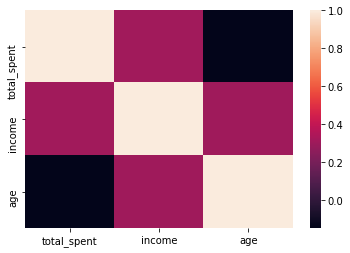

In [18]:
corr = all_profiles[['total_spent', 'income', 'age']].corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

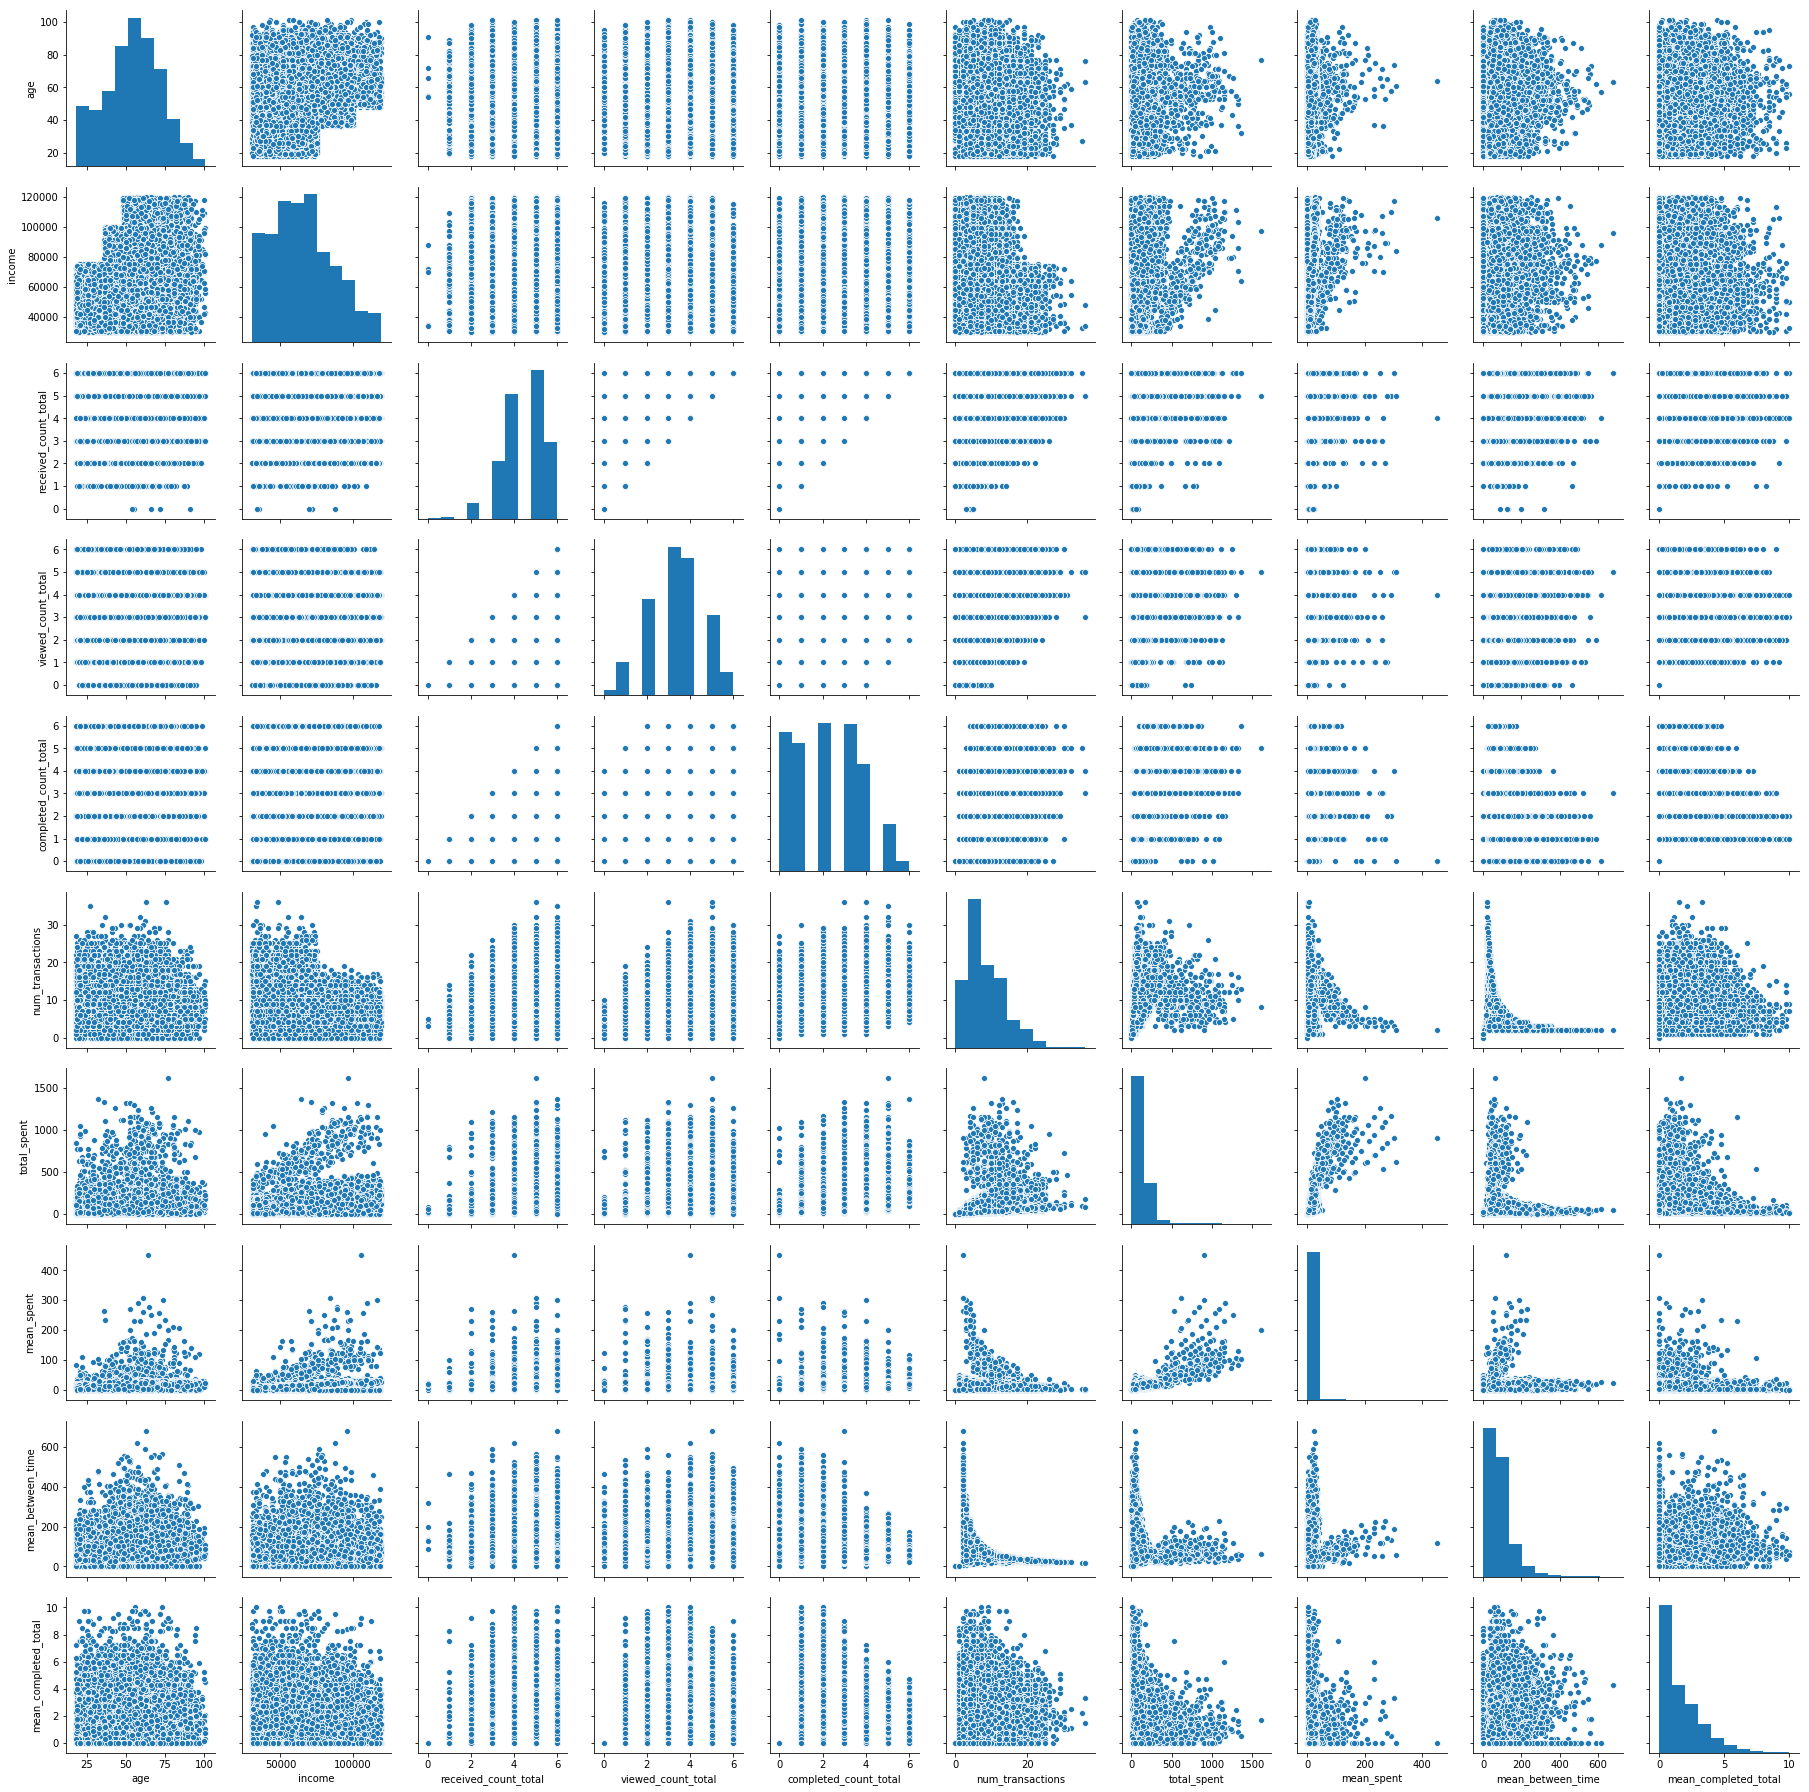

In [19]:
main_profiles = all_profiles[all_profiles['gender'].notnull()]
sns.pairplot(main_profiles[['age', 'income', 'received_count_total', 'viewed_count_total', 
                           'completed_count_total', 'num_transactions', 'total_spent',
                          'mean_spent', 'mean_between_time', 'mean_completed_total']]);

Across all genders, the higher income one has, the higher amount of money spent. However, there's one specific group that stands out: females in their 18-24 that earn about 75-100k a year. This group, on average, has the highest amount of money spent among all, although they are from the youngest age group and not in the highest-paid income bucket.  

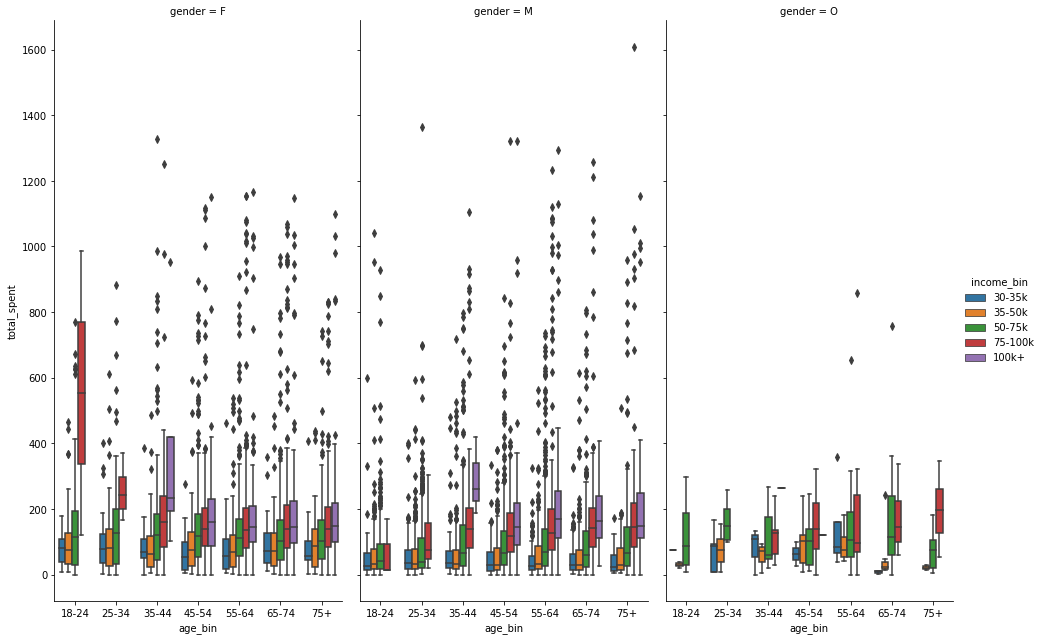

In [20]:
all_profiles = (
    all_profiles    
    .assign(age_bin=lambda x: x['age'].apply(cut_age),
            income_bin=lambda x: x['income'].apply(cut_income))
)
sns.catplot(x='age_bin', y='total_spent', hue ='income_bin', col='gender', kind='box',
            data=all_profiles.sort_values(['age_bin', 'income_bin']), height=9, aspect=0.5);

## Imputation 

As mentioned earlier, there are 2,175 obs from customers who might not want to disclose their information (thus, no valid `age`, `gender`, and `income` values). Instead of dropping these rows, we build a random forest and a XGBoost model based on all other variables, and select the best one to predict the values of these three. 

### For `age` and `income`

In [21]:
main_profiles = (
    all_profiles
    .query('gender.notnull()', engine='python')
    .reset_index(drop=True)
)
unspecified_profiles = (
    all_profiles
    .query('gender.isnull()', engine='python')
    .reset_index(drop=True)
)

In [22]:
X = main_profiles.drop(['gender', 'age', 'id', 'income', 'age_bin', 'income_bin'], axis=1)
Y_num = main_profiles[['age', 'income']]
y_cat = main_profiles['gender']

X_to_impute = unspecified_profiles.drop(['gender', 'age', 'id', 'income', 'age_bin', 'income_bin'], axis=1)

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_num, test_size=.2, random_state=42)

In [24]:
multi_rf_reg = MultiOutputRegressor(RandomForestRegressor(random_state=42))
multi_rf_reg.fit(X_train, Y_train)
Y_pred = multi_rf_reg.predict(X_test)

In [25]:
print('R-squared score of random forest model to predict age:', 
      r2_score(Y_test.iloc[:, 0], Y_pred[:, 0]))
print('R-squared score of random forest model to predict income:', 
      r2_score(Y_test.iloc[:, 1], Y_pred[:, 1]))

R-squared score of random forest model to predict age: 0.09032293372927214
R-squared score of random forest model to predict income: 0.7087258042253499


In [26]:
multi_xb_reg = MultiOutputRegressor(xgb.XGBRegressor(random_state=42, learning_rate=0.01, 
                                                     n_estimators=500))
multi_xb_reg.fit(X_train, Y_train)
Y_pred = multi_xb_reg.predict(X_test)

[19:52:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
print('R-squared score of XGBoost model to predict age:', 
      r2_score(Y_test.iloc[:, 0], Y_pred[:, 0]))
print('R-squared score of XGBoost model to predict income:', 
      r2_score(Y_test.iloc[:, 1], Y_pred[:, 1]))

R-squared score of XGBoost model to predict age: 0.11018798552261266
R-squared score of XGBoost model to predict income: 0.7098404533115727


Since XGBoost model outperforms random forest in both `age` and `income` model based on $R^2$ score, we will use XGBoost for the final imputation. 

In [28]:
imputed_y = multi_xb_reg.predict(X_to_impute)
unspecified_profiles['age'] = pd.Series(imputed_y[:, 0])
unspecified_profiles['income'] = pd.Series(imputed_y[:, 1])

### For `gender`

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=.2, random_state=42)

Since the data seems pretty balanced between genders, we don't need to take measures to alleviate the imbalanced classification problem here. 

In [30]:
y_train.value_counts()

M    6792
F    4904
O     164
Name: gender, dtype: int64

In [31]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train, y_train)
y_pred = rf_cf.predict(X_test)

In [32]:
rf_cm = confusion_matrix(y_test, y_pred)

In [33]:
print('Confusion matrix for random forest model to predict gender: ', rf_cm)
print('Classification accuracy:', np.sum(np.diagonal(rf_cm)) / len(y_test) * 100)

Confusion matrix for random forest model to predict gender:  [[ 637  588    0]
 [ 517 1175    0]
 [  19   29    0]]
Classification accuracy: 61.11298482293424


In [34]:
xb_cf = xgb.XGBClassifier(random_state=42, learning_rate=0.01, n_estimators=500)
xb_cf.fit(X_train, y_train)
y_pred = xb_cf.predict(X_test)

In [35]:
xb_cm = confusion_matrix(y_test, y_pred)

In [36]:
print('Confusion matrix for XGBoost model to predict gender: ', xb_cm)
print('Classification accuracy:', np.sum(np.diagonal(xb_cm)) / len(y_test) * 100)

Confusion matrix for XGBoost model to predict gender:  [[ 661  564    0]
 [ 536 1156    0]
 [  19   29    0]]
Classification accuracy: 61.28161888701518


In [37]:
unspecified_profiles['gender'] = pd.Series(xb_cf.predict(X_to_impute))

The classification accuracy of XGBoost model is slightly better than that of random forest. Thus, we also use XGBoost for `gender` imputation.

In [38]:
imputed_all_profiles = pd.concat([main_profiles, unspecified_profiles])

In [39]:
# check to see there's no missing values across all columns
sum(imputed_all_profiles.isnull().mean())

0.0

## Feature Transformation

In [40]:
modeling_data = (
    imputed_all_profiles
    .drop(['id', 'age_bin', 'income_bin'], axis=1)
    .reset_index(drop=True)
)
# transform `gender` into multiple dummy variables 
modeling_data = pd.get_dummies(modeling_data, columns=['gender'], prefix_sep='_')

Since K-means clustering is an unsupervised approach that is based on Euclidean distance, we need to approrirately normalize all our features. Not to mention, given that we have more than 50 features in our dataset, we might want to employ Principal Component Analysis (PCA) for dimensionality reduction, which also requires features to be normalized. 

In [41]:
# rescale the features such that they have the properties of a standard normal 
# distribution with a mean of zero and a standard deviation of one
scaler = StandardScaler()
X = scaler.fit_transform(modeling_data)

## Dimensionality reduction with PCA

In [42]:
# choose the minimum number of PC such that 95% of the variance is retained
pca = PCA(.95)  
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [43]:
print('Number of components after reduction:', pca.n_components_)
print('Explained variance associated with these components:', pca.explained_variance_)

Number of components after reduction: 32
Explained variance associated with these components: [6.42342731 6.06043667 3.87301235 3.39170476 3.31790558 3.11615073
 2.96226352 2.90466485 2.78864337 2.50923231 2.00820231 1.9046911
 1.49118703 1.42738632 1.16870446 1.08797266 1.01234866 0.99829657
 0.92105319 0.88945899 0.7547596  0.72650819 0.68959638 0.68291409
 0.64615995 0.59501951 0.591902   0.57636001 0.55262282 0.49324155
 0.41014654 0.36889798]


By using PCA, we reduce the number of features from 58 to 32 and retain at least 95% of variance. These transformed 32 features will then be fed into K-means model to cluster customers into different groups.

In [44]:
pca_transformed = pca.transform(X)

## K-means clustering

The main input for K-means algorithm to work is `k` or the number of clusters. To give us some intuition about what a good `k` number should be in this exercise, we will employ the Elbow method which is based on the within-cluster sum of squared distance (WCSS) between data points and their assigned clusters’ centroids. We'll pick `k` at the spot where WCSS starts to flatten out and form an elbow. 

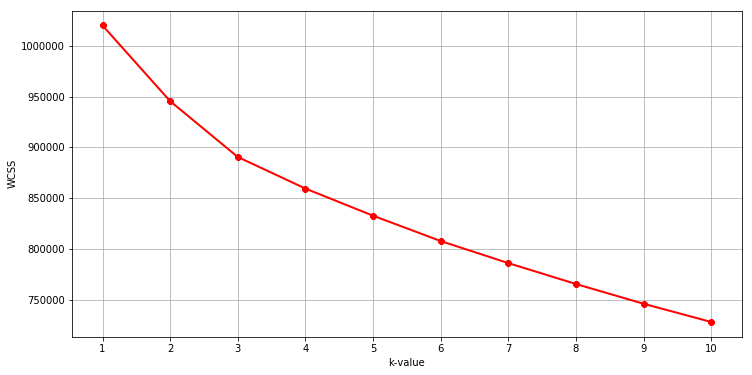

In [45]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12, 6))    
plt.grid()
plt.plot(range(1, 11),wcss, linewidth=2, color='red', marker ='8')
plt.xlabel('k-value')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('WCSS')
plt.show()

`k=3` seems to be the best choice here. It's still a little hard to figure out a good number of clusters to use based on the graph above because the curve is monotonically decreasing and does not show any elbow or has an obvious point where the curve starts flattening out. 

In [46]:
km = KMeans(n_clusters=3, random_state=42)
clusters = km.fit_predict(pca_transformed)
pca_df = pd.DataFrame(pca_transformed)
pca_df['cluster'] = clusters
pca_df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,cluster
0,-3.054602,-0.666871,-0.183046,-1.295334,-3.394198,0.937582,0.737097,1.855821,-2.546552,-2.784156,...,-0.532425,-0.098222,0.743993,-0.245913,-0.524354,0.709984,0.739558,0.649694,0.144278,2
1,-0.596198,5.703074,2.122188,-0.080701,-0.647415,1.033155,3.926172,2.140249,0.553398,-1.068158,...,3.581967,-0.755140,-0.726562,-0.974875,0.428705,1.712354,-0.309323,0.240311,0.593161,1
2,0.362357,-0.840115,-0.412767,1.306690,-1.983583,0.450593,0.652221,3.733109,2.062117,-0.732965,...,1.534058,-1.467676,-1.198884,-0.441979,1.086900,1.562212,0.257278,0.862687,-1.096811,2
3,3.225231,4.750237,-1.022815,1.755049,0.714057,5.623598,-1.950181,2.557387,5.711468,-0.362904,...,0.028695,3.830697,-0.943476,0.205453,0.811314,1.497517,-1.364039,0.042330,-0.392647,1
4,0.188889,-3.789435,-1.596933,1.946817,0.210590,-0.448636,0.510659,0.693728,-1.306831,-1.104096,...,-0.276606,-0.008945,-1.410931,0.063340,-1.286092,0.099123,0.201822,0.658660,-0.628400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,-0.622148,-1.434013,-1.364143,-1.048100,1.092430,2.040948,-0.933227,-0.748387,0.862372,0.269604,...,0.277124,-0.089780,0.266477,0.255100,-0.886985,0.656461,0.677000,-0.280549,-1.293653,2
16996,4.517862,-3.753574,-2.662323,1.877439,2.421934,-1.468860,1.089670,0.214815,0.645990,-1.216795,...,-0.503802,-0.859731,1.156267,0.886173,-0.064987,-1.331259,2.102261,0.023124,-1.646540,0
16997,-0.604791,-2.747576,-0.908995,-1.702030,2.685549,0.613988,-0.808465,-0.651640,1.713354,0.227632,...,0.249442,-0.352049,-0.368353,-0.411107,-1.498182,-0.007849,0.015504,-1.046012,-0.880711,2
16998,-4.303481,-1.458359,0.557871,0.034276,-0.363160,-0.299706,1.339636,-0.746268,-0.306172,-0.437596,...,-0.181365,-0.213057,0.868147,0.019126,-0.473709,0.663547,0.061246,-0.225409,0.110801,2


## Model analysis

In [47]:
def melt_centers_df(centers_df, condition):
    """
    Convert data frame that includes values of cluster centroids across different variables
    from wide to long format and filter them based on specified condition
    :param centers_df: original dataframe about cluster centroids
    :param condition: condition string to be supplied to pandas `query` operation
    :return: melted and filtered data frame 
    """
    return (
        centers_df
        .melt(id_vars='cluster', var_name='metric')
        .query(condition, engine='python')
        .reset_index(drop=True)
    )

    
def plot_centers_by_var(df):
    """
    Create bar plot based on processed dataframe
    :param df: dataframe returned from melt_centers_df() function
    :return: bar plot
    """
    (
        sns.catplot(x='metric', y='value', hue='cluster', data=df, kind='bar', height=9, aspect=1.5)
        .set_xticklabels(rotation=45, horizontalalignment='right')
    );

Back to our original problem statement, we would want to identify the characteristics of different demographic groups and how they respond to various offer types. To do that, we investigate the centroids of 3 labeled clusters across different variables ranging from demographic information such as gender, age, and income to engagement responses such as for each customer, number of received/viewed/completed offers per type, number of transactions, average/total amount of money spent, average amount of time taken to complete a transaction as well as average amount of time between transactions. Essentially, we want to know what makes each cluster unique.

Below is our analysis based on this centroids values returned from this unsupervised model broken down into distinct variable groups. 

### Demographics

In [48]:
final_data = pd.concat([pca_df, modeling_data], axis=1)

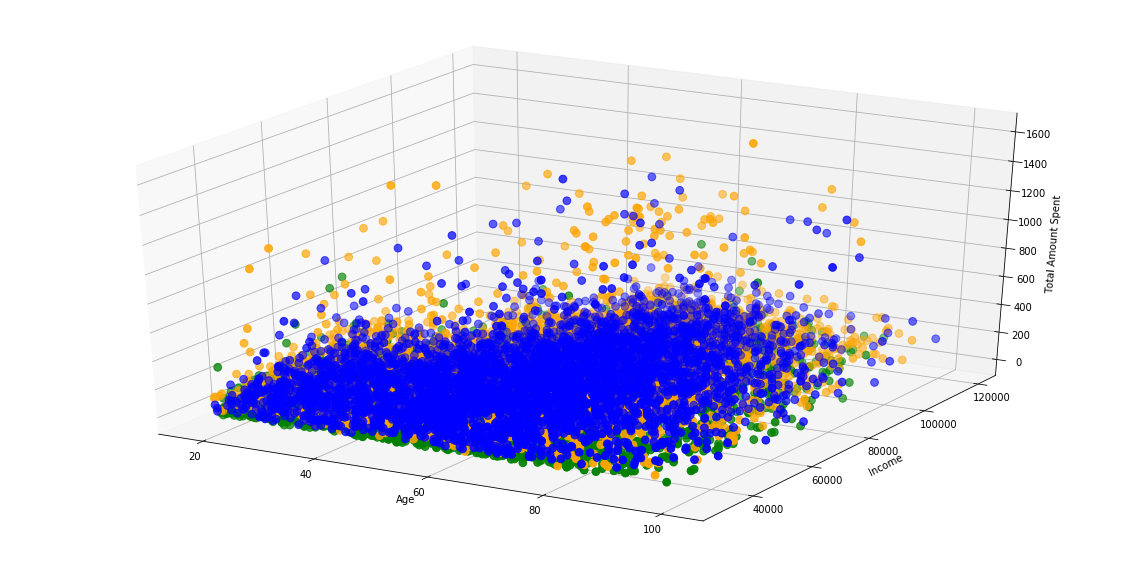

In [49]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_data[final_data['cluster'] == 0]['age'], 
           final_data[final_data['cluster'] == 0]['income'], 
           final_data[final_data['cluster'] == 0]['total_spent'], 
           c='blue', s=60)
ax.scatter(final_data[final_data['cluster'] == 1]['age'], 
           final_data[final_data['cluster'] == 1]['income'], 
           final_data[final_data['cluster'] == 1]['total_spent'], 
           c='orange', s=60)
ax.scatter(final_data[final_data['cluster'] == 2]['age'], 
           final_data[final_data['cluster'] == 2]['income'], 
           final_data[final_data['cluster'] == 2]['total_spent'], 
           c='green', s=60)
plt.xlabel('Age')
plt.ylabel('Income')
ax.set_zlabel('Total Amount Spent')
plt.show()

The main take-away from this 3D visualization is that age, income, and expenses distribution of these three clusters are very similar (and even seem homogeneous). The slightly more obvious difference is that cluster blue and orange include a larger number of high spenders than the other (green). 

In [50]:
centers = km.cluster_centers_
centers_pca = pca.inverse_transform(centers)
centers_raw = scaler.inverse_transform(centers_pca)
centers_df = pd.DataFrame(centers_raw, columns=modeling_data.columns)
centers_df['cluster'] = [0, 1, 2]
centers_df.filter(['cluster', 'age', 'income', 'member_year', 'member_month', 'member_date', 
                   'gender_F', 'gender_M', 'gender_O'])

,cluster,age,income,member_year,member_month,member_date,gender_F,gender_M,gender_O
0,0,54.509353,65902.723408,2016.440592,6.766388,15.763163,0.408518,0.579804,0.011678
1,1,56.277779,70399.819989,2016.424119,6.749268,16.051308,0.504475,0.478382,0.017143
2,2,51.595715,57445.955921,2016.884942,6.591077,15.859081,0.246444,0.743292,0.010264


Digging deeper into the actual values of demographic variables of three centroids, we see that there is generally not a clear difference between them in terms of age, when they become a member on Starbucks app, or even arguably income. For example, these three centroids still belong to the same age bucket and income bucket, using binning rule in common demographic survey questions. However, if we demand a higher level of granularity, we can say that on average, cluster 1 is about 2 years older than cluster 0, which is about 3 years older than cluster 2. Similarly, cluster 1 is a higher income group than cluster 0 (difference of about 5K/year), which is a higher income group than cluster 2 (difference of about 8K/year). These two trends are consistent with our intuitions as well, which is the older one is, the higher income one earns. In terms of gender, cluster 0 and 1 have a reasonably fair distribution between females and males; cluster 2, however, is composed of more than 70% males. 

### BOGO offers

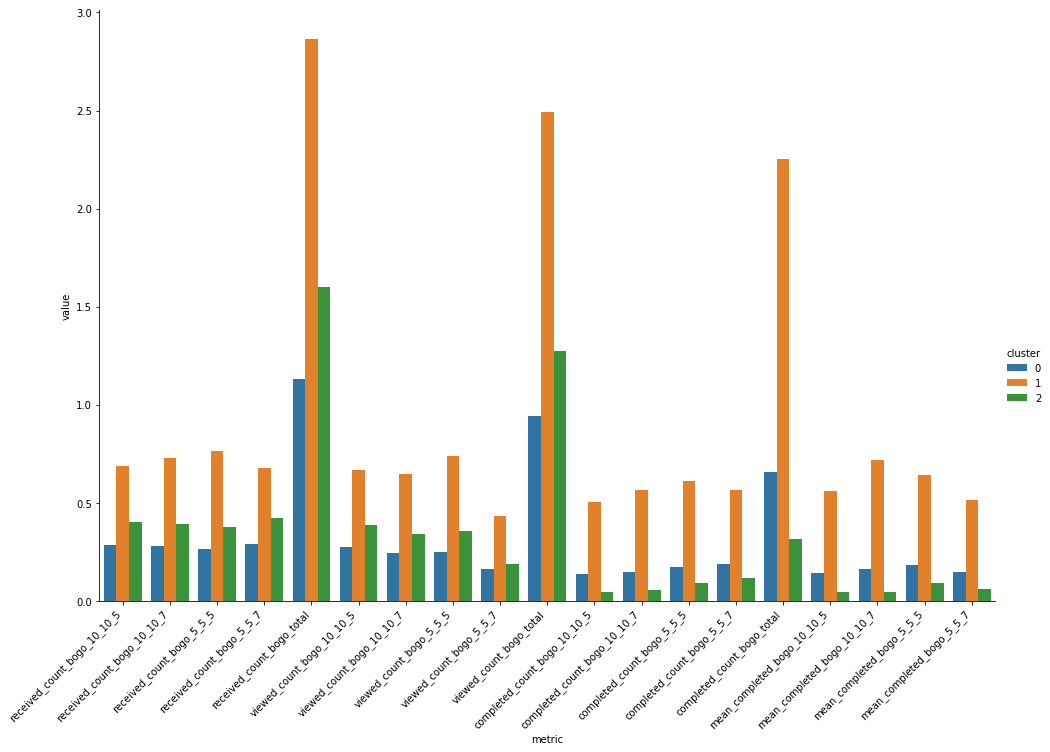

In [51]:
bogo_centers = melt_centers_df(centers_df, 'metric.str.contains("bogo")')
plot_centers_by_var(bogo_centers)

When it comes to BOGO offers, cluster 1 (orange) consistently receives/views/completes the highest number of offers, followed by cluster 2 (green) then 0 (blue) in terms of received and viewed count, or cluster 0 then 1 in terms of both completed count and average time taken to complete the offer. Note here that whereas completed count takes into consideration both customers who are under the influence of the offers and those who are not, average time taken to complete offer only applies to those who have viewed the promotion. 

### Discount offers

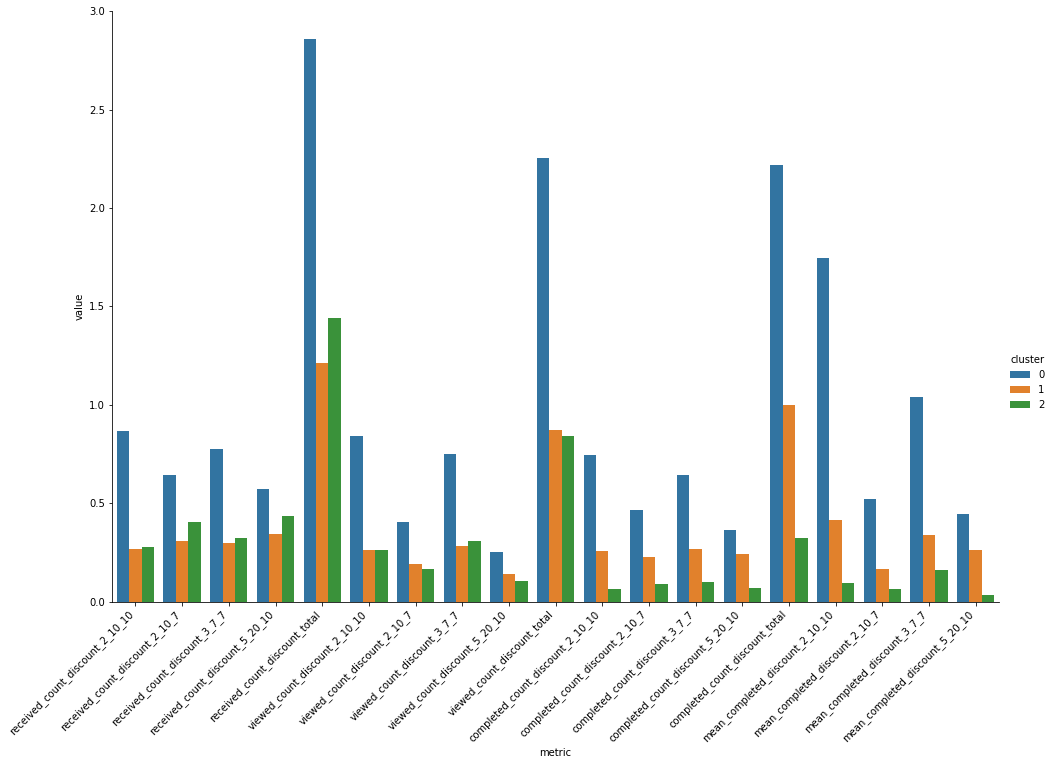

In [52]:
discount_centers = melt_centers_df(centers_df, 'metric.str.contains("discount")')
plot_centers_by_var(discount_centers)

Similar story as above: cluster 0 (blue) is clearly the most responsive among the three when it comes to discount offers. Who is the runner-up depends on what engagement response and offer combination we're interested in.

### Informational offers

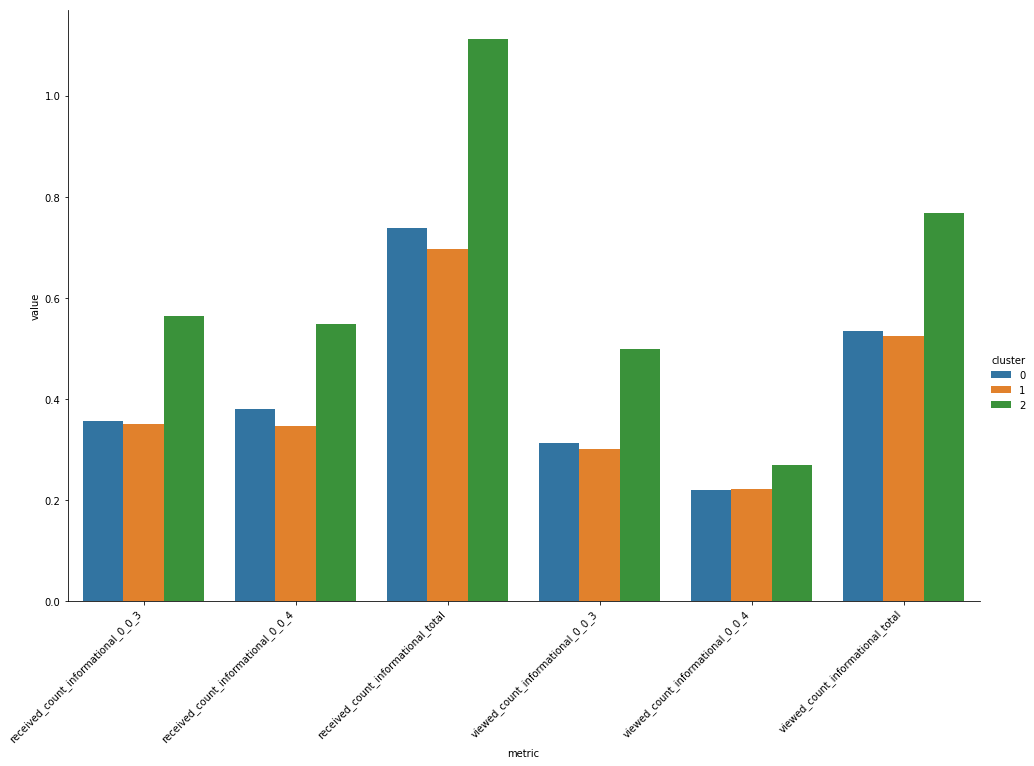

In [53]:
info_centers = melt_centers_df(centers_df, 'metric.str.contains("informational")')
plot_centers_by_var(info_centers)

Cluster 2 (green) is the most engaging group to informational offers - they not only receive but also view these messages most often. 

###  Transactional behaviors

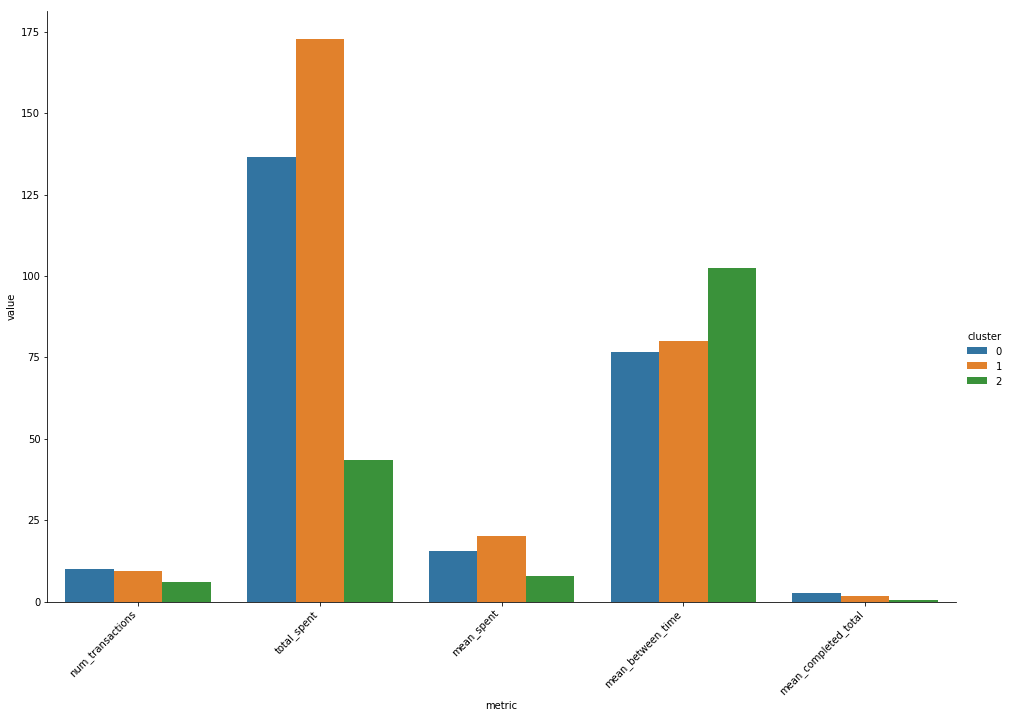

In [54]:
trans_cols = ['num_transactions', 'total_spent', 'mean_spent', 'mean_between_time', 'mean_completed_total']
trans_centers = melt_centers_df(centers_df, 'metric in @trans_cols')
plot_centers_by_var(trans_centers)

Although cluster 0 (blue) purchases more often and takes the shortest amount of time between transactions, cluster 1 (orange) tends to spend a higher amount of money over time. Consistent with our insights above, cluster 2 (green) seems to be the least responsive - they make the fewest number of transactions, spend the least amount of money, and take the longest time between purchases compared with the rest. Interestingly enough, once they are under the influence of promotional offers and complete those, they take the least amount of time.  

## Conclusions

After building a k-means clustering model, we are able to identify three main customer segments: 

- The Big Spenders: They actively engage with BOGO offers and seem to be the most valuable group to Starbucks since they spend the highest amount of money and make a good number of transactions. Their gender ratio between male and female is almost 1:1. Mean age of these spenders are 56 years old and they earn about 70K/year averagely. 
- The Discount Lovers: They are highly responsive to discount offers and tend to make the most number of purchases compared with other two groups. They also spend a decent amount of money on Starbucks over time, despite not being the highest group. They have a fair distribution of males and females. The average age of customers in the group is 54 and average income is about 65K/year.
- The Lurkers: Although they do not participate much in BOGO and discount offers' activities, they tend to keep up-to-date with informational messages. However, this group doesn't significantly contribute to Starbucks' revenue since they make the fewest number of transactions, spend the least amount of money, and take the longest time between purchases compared with the rest. The group is composed of 70% males. The average age of customers in the segment is 51 and average income is about 57K/year. 